<a href="https://colab.research.google.com/github/Maharshii5/DLMLGEEK/blob/main/LSTM%20VS%20XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/30



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 0.0302
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 0.0015
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 9.6444e-04
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 8.5613e-04
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 9.1114e-04
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 9.0484e-04
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.2601e-04
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 7.9690e-04
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 8.0722e-04
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 7.6704e-04
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - loss: 6.2025e-04
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 5.2992e-04
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 6.7868e-04
Epoch 15/30
29/29 ━━━━

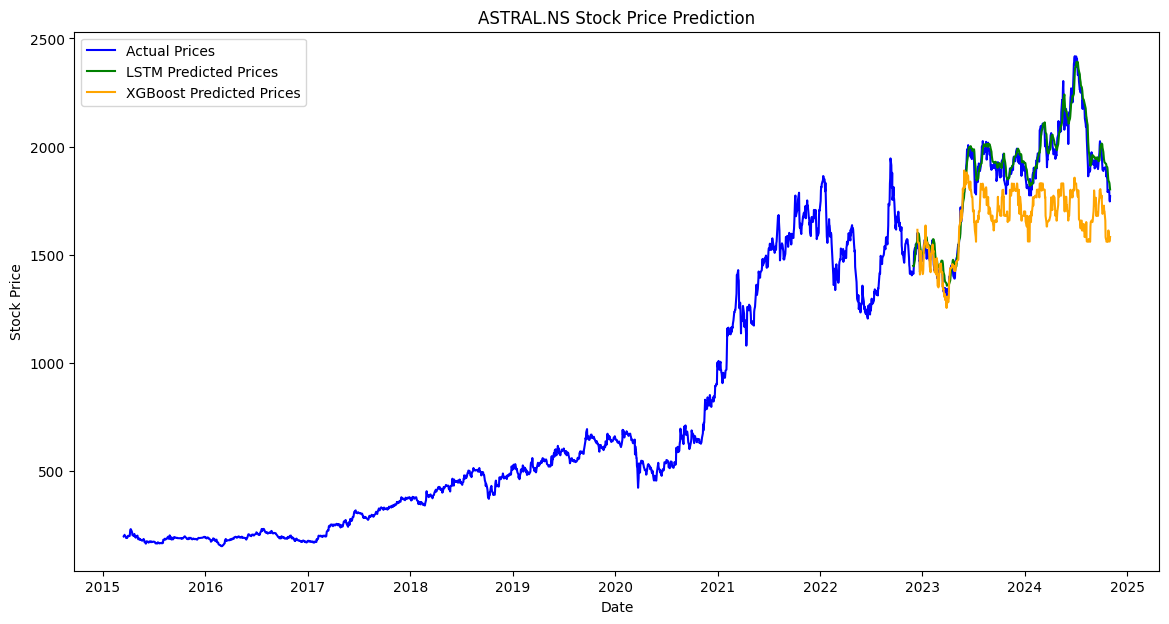

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from prophet import Prophet

# Download stock data
stock_symbols = ['ASTRAL.NS']  # Add more stock symbols as needed
company_predictions = {}

for symbol in stock_symbols:
    # Step 1: Load and Preprocess Data
    data = yf.download(symbol, start='2015-01-01', end='2024-11-01')
    data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
    data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()  # 20-day Exponential Moving Average
    # Calculate RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    data.dropna(inplace=True)  # Drop any NaN values from indicators

    # Scale the 'Close' prices for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Prepare Training Data for LSTM
    train_data_len = int(np.ceil(len(scaled_data) * 0.8))
    train_data = scaled_data[0:train_data_len, :]

    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Step 2: Define a More Advanced LSTM Model
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1))),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=64, epochs=30)

    # Step 3: Prepare Data for XGBoost
    # Use the last 60 days for each point in time to create a dataset for XGBoost
    xgb_data = data[['SMA_20', 'SMA_50', 'EMA_20', 'RSI']].iloc[60:]
    y_xgb = data['Close'][60:]

    # Train-test split for XGBoost
    train_len = int(len(xgb_data) * 0.8)
    xgb_train, xgb_test = xgb_data[:train_len], xgb_data[train_len:]
    y_xgb_train, y_xgb_test = y_xgb[:train_len], y_xgb[train_len:]

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    xgb_model.fit(xgb_train, y_xgb_train)

    # Step 4: Model Evaluation (LSTM)
    test_data = scaled_data[train_data_len - 60:, :]
    x_test, y_test = [], data['Close'][train_data_len:]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    lstm_predictions = model.predict(x_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Step 5: Model Evaluation (XGBoost)
    xgb_predictions = xgb_model.predict(xgb_test)

    # Calculate RMSE and MAPE for LSTM and XGBoost
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
    lstm_mape = mean_absolute_percentage_error(y_test, lstm_predictions)

    xgb_rmse = np.sqrt(mean_squared_error(y_xgb_test, xgb_predictions))
    xgb_mape = mean_absolute_percentage_error(y_xgb_test, xgb_predictions)

    print(f"{symbol} LSTM Model - RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape*100:.2f}%")
    print(f"{symbol} XGBoost Model - RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape*100:.2f}%")

    # Step 6: Plot both actual prices and ensemble predictions
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Actual Prices', color='blue')
    plt.plot(data.index[train_data_len:], lstm_predictions, label='LSTM Predicted Prices', color='green')
    plt.plot(y_xgb_test.index, xgb_predictions, label='XGBoost Predicted Prices', color='orange')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Save predictions
    company_predictions[symbol] = {
        "LSTM": pd.DataFrame({"Date": y_test.index, "Predicted": lstm_predictions.flatten()}),
        "XGBoost": pd.DataFrame({"Date": y_xgb_test.index, "Predicted": xgb_predictions})
    }

